# **Задание по итогам курса:**

- (упрощенное/для тех, у кого нет вебкамеры)
    1. Нужно написать приложение, которое будет получать на вход *изображение*.
    2. В процессе определять, что перед камерой находится человек, задетектировав его лицо на кадре.
    3. На изображении человек показывает жесты руками, а алгоритм должен считать их и классифицировать.

- (более сложное)
    1. Нужно написать приложение, которое будет считывать и выводить кадры с *веб-камеры*.
    2. В процессе считывания определять что перед камерой находится человек, задетектировав его лицо на кадре.
    3. Человек показывает жесты руками, а алгоритм должен считать их и классифицировать.
____________________
- Для распознавания жестов, вам надо будет скачать датасет https://www.kaggle.com/gti-upm/leapgestrecog, разработать модель для обучения и обучить эту модель.
- Как работать с веб-камерой на google colab https://stackoverflow.com/questions/54389727/opening-web-camera-in-google-colab


У кого нет возможности работать через каггл (нет верификации), то можете данные взять по ссылке: https://disk.yandex.ru/d/R2PGlaXDf6_HzQ

## 1 Подключение библиотек

In [4]:
import os
import cv2
import time
import torch
import shutil
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as tt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.optim as opt
from google.colab import drive
from torchvision.utils import make_grid
from torch.autograd import Variable
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torchvision import models
from torchsummary import summary

In [5]:
# @title Проверка подключения к среде выполнения
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.1 Определение основных функций и классов

In [6]:
def makeDir(dir_name):
    if os.path.exists(dir_name):
        shutil.rmtree(dir_name)
    os.makedirs(dir_name)


class MyOwnHandDataset(torch.utils.data.Dataset):
    def __init__(self, data, preprocessing=None):
        self.data = data
        self.preprocessing = preprocessing
        self.images_paths = self.data.iloc[:, 0]
        self.label = self.data.iloc[:, 1]
        self.data_len = len(self.data.index)

    def __len__(self):
        return self.data_len

    def __getitem__(self, idx):
        img_path = self.images_paths[idx]
        label = self.label[idx]
        img = Image.open(img_path)

        if self.preprocessing:
            img = self.preprocessing(img)

        return img, label

def Model_fit(Model, X, y, model_epochs, model_optimizers, model_losses, logit_step, device):
    Model.train()
    start = time.time()
    train_accuracy_all = []
    train_loss_all = []


    for epoch in range(model_epochs):
        running_loss, running_items, running_right = 0.0, 0.0, 0.0
        for batch_idx, (data, labels) in enumerate(train_dl):
            data = data.to(device)
            labels = labels.to(device)

            # обнуляем градиент
            model_optimizers.zero_grad()

            outputs = Model(data)
            loss = model_losses(outputs, labels)
            loss.backward()
            model_optimizers.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(labels)
            running_right += (labels == torch.max(outputs, 1)[1]).sum()

            # выводим статистику о процессе обучения
            if (batch_idx+1) % logit_step == 0:    # печатаем каждые 300 mini-batches
                Model.eval()

                print("", end=f'\rEpoch [{epoch + 1}/{model_epochs}]. ' \
                                f'Loss: {running_loss / running_items:.3f}. ' \
                                f'Acc: {running_right / running_items:.3f}. ')

                train_accuracy_all.append(running_right / running_items)
                train_loss_all.append(running_loss / running_items)

                running_loss, running_items, running_right = 0.0, 0.0, 0.0

                test_running_right, test_running_total = 0.0, 0.0
                for i, data in enumerate(y):

                    test_outputs = Model(data[0].to(device))
                    test_running_total += len(data[1])
                    test_running_right += (data[1].to(device) == torch.max(test_outputs, 1)[1]).sum()

                print("", end=f'Test acc: {test_running_right / test_running_total:.3f}')

            Model.train()

    stop = time.time()
    print(f'\nTraining is finished! It took {round((stop - start), 2)} seconds')
    plt.plot(train_loss_all)
    plt.show()
    return train_accuracy_all, train_loss_all

## 2 Загрузка датасета

In [7]:
drive.mount("/content/drive/")

Mounted at /content/drive/


In [8]:
home_dir = "/content/drive/MyDrive/"

In [9]:
work_dir_hand = "Hand/"

In [ ]:
# makeDir(home_dir + work_dir_hand)

In [ ]:
# !unzip "/content/drive/MyDrive/arhive_hand.zip" -d "/content/drive/MyDrive/Hand/"

In [ ]:
# os.rename(home_dir + work_dir_hand + "leapGestRecog", home_dir + work_dir_hand + "train")
# os.rename(home_dir + work_dir_hand + "leapgestrecog", home_dir + work_dir_hand + "test")
# os.rename(home_dir + work_dir_hand + "test/leapGestRecog", home_dir + work_dir_hand + "test/move_test")
# shutil.move(home_dir + work_dir_hand + "test/move_test", home_dir + work_dir_hand)
# shutil.rmtree(home_dir + work_dir_hand + "test")
# os.rename(home_dir + work_dir_hand + "move_test", home_dir + work_dir_hand + "test")

In [ ]:
# work_folder = os.listdir(home_dir + work_dir_hand)
# work_folder

## 3 Определение трансформаций

In [21]:
train_transformations = tt.Compose([tt.Grayscale(num_output_channels=3),
                                    tt.Resize([128,128]),
                                    tt.RandomHorizontalFlip(),
                                    tt.RandomRotation(30),
                                    tt.ToTensor()])

test_transformations = tt.Compose([tt.Grayscale(num_output_channels=3),
                                   tt.Resize([128,128]),
                                   tt.ToTensor()])

## 4 Создание рабочего датасета

In [ ]:
# frame = "train"
# main_dict = {}
# full_img_path = []
# label_list = []
# for dir in os.listdir(home_dir + work_dir_hand + frame):
#     for d in os.listdir(home_dir + work_dir_hand + frame + "/" + dir):
#         for f in os.listdir(home_dir + work_dir_hand + frame + "/" + dir + "/" + d):
#             full_img_path.append(home_dir + work_dir_hand + frame + "/" + dir + "/" + d + "/" + f)
#             label_list.append(d)
# main_dict['main_img'] = full_img_path
# main_dict['label'] = label_list

In [ ]:
# df = pd.DataFrame(main_dict)
# df.head()

In [ ]:
# df.count()

In [ ]:
# print(df['main_img'][0], "\n\n", df['label'][0])

### 4.1 Сохранение рабочего датасета

In [ ]:
# df.to_csv(home_dir + "hand.csv", sep=",")

### 4.2 Загрузка рабочего датасета

In [10]:
df_new = pd.read_csv(home_dir + "hand.csv", sep=",")
df_new.drop(['Unnamed: 0'], axis=1, inplace=True)
df = df_new.copy()

### 4.3 Определение классов целевой переменной

In [11]:
target_feature = list(set(df["label"]))
target_feature.sort()
target_feature

['01_palm',
 '02_l',
 '03_fist',
 '04_fist_moved',
 '05_thumb',
 '06_index',
 '07_ok',
 '08_palm_moved',
 '09_c',
 '10_down']

In [12]:
df.head()

,main_img,label
0,/content/drive/MyDrive/Hand/train/00/01_palm/f...,01_palm
1,/content/drive/MyDrive/Hand/train/00/01_palm/f...,01_palm
2,/content/drive/MyDrive/Hand/train/00/01_palm/f...,01_palm
3,/content/drive/MyDrive/Hand/train/00/01_palm/f...,01_palm
4,/content/drive/MyDrive/Hand/train/00/01_palm/f...,01_palm


### 4.4 Категоризация целевой переменной


In [13]:
for i in range(len(target_feature)):
    # print(i+1, target_feature[i])
    df.loc[df['label'] == target_feature[i], "label"] = i

In [14]:
df.head()

,main_img,label
0,/content/drive/MyDrive/Hand/train/00/01_palm/f...,0
1,/content/drive/MyDrive/Hand/train/00/01_palm/f...,0
2,/content/drive/MyDrive/Hand/train/00/01_palm/f...,0
3,/content/drive/MyDrive/Hand/train/00/01_palm/f...,0
4,/content/drive/MyDrive/Hand/train/00/01_palm/f...,0


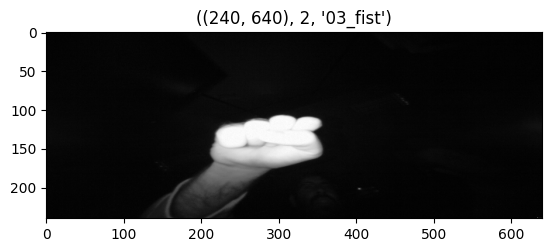

In [15]:
num_img = 8546
imgplot = plt.imread(df['main_img'][num_img])
plt.title((imgplot.shape, df['label'][num_img], df_new['label'][num_img]))
plt.imshow(imgplot, cmap="gray")

### 4.5 Разделение на тренировочный и тестовый датасеты

In [16]:
df_train, df_test = train_test_split(df, test_size=0.25)

In [17]:
df_train.count()

main_img    15000
label       15000
dtype: int64

In [18]:
df_test.count()

main_img    5000
label       5000
dtype: int64

In [19]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

## 5 Запись в Dataset

In [22]:
train_ds = MyOwnHandDataset(df_train, train_transformations)
test_ds = MyOwnHandDataset(df_test, test_transformations)

## 6 Запись в DataLoader

In [23]:
batch_size = 64

In [24]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2)
test_dl = DataLoader(test_ds, batch_size, shuffle=False, num_workers=1)

## 7 Загрузка модели Resnet-50

In [ ]:
resnet_50 = models.resnet50(pretrained=True)
# summary(resnet_50.to(device), input_size=(3, 128, 128))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 8 Блокировка весов на обученой модели

In [ ]:
for param in list(resnet_50.parameters())[:]:
    param.requires_grad = False

## 9 Перезапись последнего слоя модели

In [ ]:
num_features = resnet_50.fc.in_features
num_features

2048

In [ ]:
out_feature = len(target_feature)
out_feature

10

In [ ]:
resnet_50.fc = nn.Linear(num_features, out_feature)

In [ ]:
# summary(resnet_50.to(device), input_size=(3, 128, 128))

## 10 Определение оптимизатора и функции потерь

### 10.1 Определение весов для оптимизатора

In [ ]:
weights_for_optimizer = []
for _, param in resnet_50.named_parameters():
    if param.requires_grad == True:
        weights_for_optimizer.append(param)

In [ ]:
optimizer_50 = torch.optim.Adam(weights_for_optimizer, lr=0.001)
criterion_50 = nn.CrossEntropyLoss().to(device)

## 11 Дообучение модели

Epoch [10/10]. Loss: 0.003. Acc: 0.935. Test acc: 0.911
Training is finished! It took 19992.65 seconds


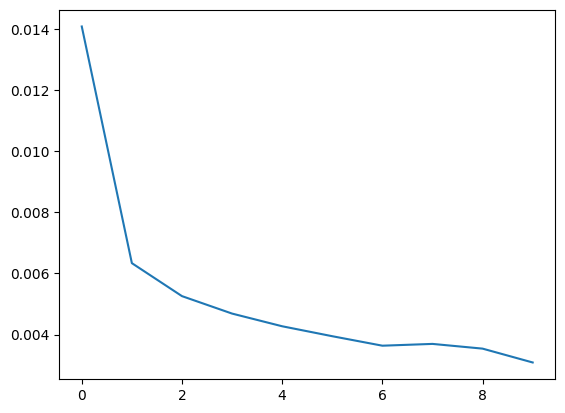

In [ ]:
acc, loss = Model_fit(resnet_50, train_dl, test_dl, 10, optimizer_50, criterion_50, 150, device)

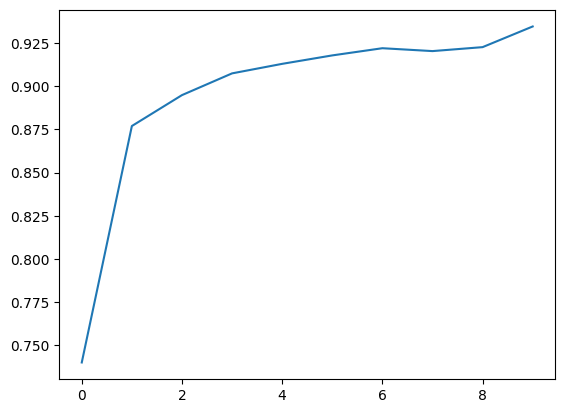

In [ ]:
plt.plot(acc)

## 13 Сохранение и загрузка модели

In [2]:
PATH_DIR = '/content/drive/MyDrive/My_model_PT/'
PATH_MODEL = '/content/drive/MyDrive/My_model_PT/my_model_hand.pth'

In [ ]:
# if os.path.exists(PATH_DIR):
#     shutil.rmtree(PATH_DIR)
# os.makedirs(PATH_DIR)

In [ ]:
# torch.save(resnet_50, PATH_MODEL)

In [25]:
my_model = torch.load(PATH_MODEL)

## 14 Проверка модели на тестовых данных

In [30]:
with torch.no_grad():
    positive = 0
    negative = 0
    for i, data in enumerate(test_dl, 3):
        images, labels = data[0].to(device), data[1].to(device)

        outputs = my_model(images)
        print(f'pred - {target_feature[outputs[0].argmax()]}, gt - {target_feature[labels[0]]} {target_feature[outputs[0].argmax()] == target_feature[labels[0]]}')
        if target_feature[outputs[0].argmax()] == target_feature[labels[0]]:
            positive += 1
        else:
            negative += 1
        # plt.title(f'pred - {target_feature[outputs[0].argmax()]}, gt - {target_feature[labels[0]]}')
        # plt.imshow(images[0].cpu().permute(1, 2, 0), cmap='gray')
        # plt.show()
        if i>11:
            break
    print(f"Совпало {positive} из {10} предсказаний")
    print(f"Не совпало {negative} из {10} предсказаний")

pred - 04_fist_moved, gt - 06_index False
pred - 09_c, gt - 09_c True
pred - 07_ok, gt - 07_ok True
pred - 07_ok, gt - 07_ok True
pred - 08_palm_moved, gt - 08_palm_moved True
pred - 02_l, gt - 02_l True
pred - 02_l, gt - 02_l True
pred - 08_palm_moved, gt - 08_palm_moved True
pred - 08_palm_moved, gt - 08_palm_moved True
pred - 07_ok, gt - 07_ok True
Совпало 9 из 10 предсказаний
Не совпало 1 из 10 предсказаний
